In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%bash
rm mesh2/system/blockMeshDict

rm: cannot remove 'mesh2/system/blockMeshDict': No such file or directory


# 00. Angle of attack

In [3]:
aoa = np.deg2rad(5)

# 0. Function importing 
(functions come from other notebooks)

In [4]:
def NACA4(s):

    #definition of the NACA profile as XXXX
    NACA = s
    c = 1 #chord line

    #NACA XXXX = m p (pt)
    m = int(int(NACA)/1e3)/1e2 #maximum camber
    p = int((int(NACA)-m*1e5)/1e2)/1e1 #location of maximum camber
    pt = int((int(NACA)-m*1e5-p*1e3)) #percentage of thickness with respect to the chord

    #figure definition
#    fig = plt.gcf()
#    fig.set_size_inches(20,12)
#    ax1 = plt.subplot(1,2,1)
#    ax2 = plt.subplot(1,2,2)
    
    #mean camber line definition
    if p != 0:
        x = np.append(np.linspace(0,p/100*c,500)[:-1],np.linspace(p/100*c,c,250))
        x_pc = x<(p*c) #masked array to create the piece-wise function

        yc1 = ((c*m)/(p**2))*(2*p*(x/c)-(x/c)**2)
        yc2 = ((c*m)/((1-p)**2))*((1-2*p)+2*p*(x/c)-(x/c)**2)

        yc = np.zeros(np.shape(x))

        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                yc[i] = yc1[i]
            else:
                yc[i] = yc2[i]

        #mean camber line derivative
        dyc1dx = (2*m)/(p**2)*(p-(x/c))
        dyc2dx = (2*m)/((1-p)**2)*(p-(x/c))

        dycdx = np.zeros(np.shape(x))

        for i in range(np.shape(x)[0]):
            if x_pc[i] == True:
                dycdx[i] = dyc1dx[i]
            else:
                dycdx[i] = dyc2dx[i]

        theta = np.arctan(dycdx)

#        ax1.plot(x,yc1,'--k',label='yc1')
#        ax1.plot(x,yc2,'-.k',label='yc2')
#        ax1.plot(x,0.01*x_pc,':',color='grey', label='Masked matrix')
#        ax1.plot(x,yc,label='Mean camber')
#        ax1.legend()
    else:
        #symmetric airfoil camber line
        x = np.linspace(0,c,750)
        yc = np.zeros(np.shape(x))

#        ax1.plot(x,yc,label='Mean camber')
#        ax1.legend()


    #thickness
    if p != 0:
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)
        xu = x - yt*np.sin(theta)
        xl = x + yt*np.sin(theta)
        yu = yc + yt*np.cos(theta)
        yl = yc - yt*np.cos(theta)

#        ax2.set_xlim(-c*0.1,1.1*c)
#        ax2.axis('equal')
#        ax2.axis('off')
#        ax2.plot(xu,yu,'b')
#        ax2.plot(xl,yl,'b')
#        ax2.fill_between(x, yu, yl,facecolor='blue',alpha=0.1)
#        ax2.plot(x,yc,'r',linewidth=0.7)
#        ax2.plot([0,c],[0,0],'g',linewidth=0.6)
        
        return xu, xl, yu, yl
        
    else:
        yt = 5*pt/100*(0.2969*np.sqrt(x/c)-0.1260*(x/c)-0.3516*(x/c)**2+0.2843*(x/c)**3-0.1036*(x/c)**4)

#        ax2.set_xlim(-c*0.1,1.1*c)
#        ax2.axis('equal')
#        ax2.axis('off')
#        ax2.plot(x,yt,'b')
#        ax2.plot(x,-yt,'b')
#        ax2.fill_between(x, -yt, yt,facecolor='blue',alpha=0.1)
#        ax2.plot(x,yc,'r',linewidth=0.7)
#        ax2.plot([0,c],[0,0],'g',linewidth=0.6)

        return x, x, yt, -yt

In [5]:
def simple_grading(N, expRatio, L):
    delta = np.zeros(N) #size of each cell array
    nodes = np.zeros(N+1) #position of the nodes

    kVal = expRatio**((1)/(N-1)) 
    k = np.zeros(N) #increment of each cell

    for i in range(N):
        k[i] = kVal**(i) 

    deltaS = L/np.sum(k)  #first cell size 

    delta = deltaS*k #size of each cell
    
    for i in range(N):
        nodes[i+1] = nodes[i] + delta[i]
        
#    return nodes, delta
    return nodes

In [6]:
def multi_grading(perc, cells, eps, N, L): 
    
    #some initial shape and value comprobations
    if np.sum(perc) != 1:
        print('Bad percentage array input')
        return

    if np.sum(cells) != 1:
        print('Bad cell array input')
        return
    
    if np.shape(perc)[0] != np.shape(cells)[0] or np.shape(perc)[0] != np.shape(eps)[0] or np.shape(cells)[0] != np.shape(eps)[0]:
        print('Non equal vector definition')
        return
        
    segmentN = (N*cells) #cells per segment
    restCells = np.modf(segmentN)[0] #in case there are decimal values
    segmentN = np.trunc(segmentN) #integer value of the cells

    i = np.sum(restCells) #distributor of the 'decimal' parts of the cells
    while i > 0:
        segmentN[np.argmax(restCells)] = segmentN[np.argmax(restCells)] + int(i)
        restCells[np.argmax(restCells)] = 0
        i -= 1
   
    segmentL = (L*perc) #length per segment

    nodes = np.zeros(N+1) #number of nodes
        
    for i in range(np.shape(perc)[0]):
        nodesTemp = simple_grading(int(segmentN[i]), eps[i], segmentL[i])
        for j in range(np.shape(nodesTemp)[0]):
            if i == 0:
                nodes[j] = nodesTemp[j]
            else:
                nodes[int(np.cumsum(segmentN)[i-1]) + j] = nodesTemp[j] + nodes[int(np.cumsum(segmentN)[i-1])]

    return nodes

In [7]:
def grading_plot(x): #nodes should be imported

    y = 0.5*np.ones(np.shape(x)[0])
    
    fig, ax = plt.subplots(figsize=(20, 1), dpi=100)
        
    ax.set_xlim(-x[1]*0.5,1.1*x[-1])
    ax.set_ylim(0,1)
    ax.axis('off')
    ax.plot([x[0],x[-1]],[y[0],y[-1]],'k')
    ax.scatter(x,y,c='k')

In [8]:
def airfoilTrueX(newX, xu, yu, xl, yl):
    yuAxis = np.interp(newX, xu, yu)
    ylAxis = np.interp(newX, xl, yl)
    return yuAxis, ylAxis

# 1. (Simplified) Header

In [9]:
with open('./mesh2/system/blockMeshDict', 'a') as bMD:
    bMD.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    bMD.write('| =========                 |                                                 | \n')
    bMD.write('| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    bMD.write('|  \\    /   O peration     | Version:  5                                     | \n')
    bMD.write('|   \\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    bMD.write('|    \\/     M anipulation  |                                                 | \n')
    bMD.write('\*---------------------------------------------------------------------------*/ \n')
    bMD.write('\n')
    bMD.write('FoamFile \n')
    bMD.write('{ \n')
    bMD.write('    version     2.0; \n')
    bMD.write('    format      ascii; \n')
    bMD.write('    class       dictionary; \n')
    bMD.write('    object      blockMeshDict;; \n')
    bMD.write('} \n')
    bMD.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n')
    bMD.write('\n')
    bMD.write('convertToMeters 1; \n')
    bMD.write('\n')

# 2. Vertices

In [10]:
maxX = 1
minX = 0
maxY = 0.01
minY = -0.01
maxZ = 0.01
minZ = 0

In [26]:
midY = (maxY+minY)/2
zero = np.array([((minX-maxX)*np.cos(aoa)midY*np.sin(aoa)),((minX-maxX)*np.sin(aoa)-midY*np.cos(aoa))])

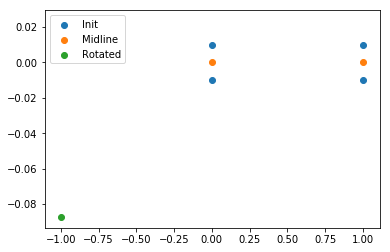

In [27]:
plt.scatter([minX,maxX,maxX,minX],[minY,minY,maxY,maxY],label='Init')
plt.scatter([minX,maxX],[midY,midY],label='Midline')
plt.scatter([zero[0]],[zero[1]],label='Rotated')
plt.legend()

In [11]:
#minX = (maxX-minX)*np.cos(aoa)
#maxX = (maxX-minX)*np.cos(aoa)

In [12]:
with open('./mesh2/system/blockMeshDict', "a") as bMD:
    bMD.write('vertices \n')
    bMD.write('( \n')
    bMD.write('    (%.2f %.2f %.2f) \n' %(minX, minY, minZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(maxX, minY, minZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(maxX, maxY, minZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(minX, maxY, minZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(minX, minY, maxZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(maxX, minY, maxZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(maxX, maxY, maxZ))
    bMD.write('    (%.2f %.2f %.2f) \n' %(minX, maxY, maxZ))
    bMD.write('); \n')
    bMD.write('\n')

# 3. Spline calculations

In [13]:
noCells = 250

perc = np.array([0.1, 0.2, 0.4, 0.3])
cells = np.array([0.3, 0.15, 0.3, 0.25])
exp = np.array([20, 1, 1, 0.6])

xAxis = multi_grading(perc, cells, exp, noCells, maxX-minX)

#grading_plot(xAxis)

In [14]:
xu, xl, yu, yl = NACA4('3612')

yuAxis, ylAxis = airfoilTrueX(xAxis, xu, yu, xl, yl)

# 4. Blocks

In [15]:
with open('./mesh2/system/blockMeshDict', "a") as bMD:
    bMD.write('blocks \n')
    bMD.write('( \n')
    bMD.write('    hex (0 1 2 3 4 5 6 7) (%i 10 1) simpleGrading \n' %noCells)
    bMD.write('    ( \n') 
    bMD.write('     ( \n') 
    for i in range(np.shape(perc)[0]):
        bMD.write('     (%.3f %.3f %.3f) \n' %(perc[i], cells[i], exp[i]))
    bMD.write('     ) \n') 
    bMD.write('    1 \n')
    bMD.write('    1 \n')
    bMD.write('    ) \n')
    bMD.write('); \n')
    bMD.write('\n')

# 5. Edges

In [16]:
with open('./mesh2/system/blockMeshDict', "a") as bMD:
    bMD.write('edges \n')
    bMD.write('( \n')
#    bMD.write('    spline 0 1 ( \n')
#    for i in range(np.shape(xAxis)[0]):
#        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i]+minY, minZ))
#    bMD.write('        ) \n')
#    bMD.write('    polyLine 3 2 ( \n')
#    for i in range(np.shape(xAxis)[0]):
#        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i]+maxY, minZ))
#    bMD.write('        ) \n')
#    bMD.write('    spline 4 5 ( \n')
#    for i in range(np.shape(xAxis)[0]):
#        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], ylAxis[i]+minY, maxZ))
#    bMD.write('        ) \n')
#    bMD.write('    polyLine 7 6 ( \n')
#    for i in range(np.shape(xAxis)[0]):
#        bMD.write('        (%.8f %.8f %.8f) \n' %(xAxis[i], yuAxis[i]+maxY, maxZ))
#    bMD.write('        ) \n')
    bMD.write('); \n')
    bMD.write('\n')

# 6. Boundary 
(left empty - just meshing purposes)

In [17]:
with open('./mesh2/system/blockMeshDict', "a") as bMD:
    bMD.write('boundary \n')
    bMD.write('( \n')
    bMD.write(' \n')
    bMD.write('); \n')

# 7. blockMesh and visualization

In [18]:
%%bash
cd mesh2/
blockMesh
paraFoam

/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  5.0                                   |
|   \\  /    A nd           | Web:      www.OpenFOAM.org                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
Build  : 5.0-dbb428a3a855
Exec   : blockMesh
Date   : Feb 02 2018
Time   : 23:40:56
Host   : "lenovoYoga"
PID    : 22879
I/O    : uncollated
Case   : /home/jlobatop/Documents/Thesis/senior-thesis/mesh-generation/mesh2
nProcs : 1
sigFpe : Enabling floating point exception trapping (FOAM_SIGFPE).
fileModificationChecking : Monitoring run-time modified files using timeStampMaster (fileModificationSkew 10)
allowSystemOperations : Allowing u